# Assignment 7: Linear Models
### Joe Leonard (ymd3tv) - DS 3001

**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?
- A model is "linear" if it is linear in its parameters, meaning the dependent variable is modeled as a linear combination of the coefficients. The predictor variables themselves can be transformed, but as long as the equation remains linear in the coefficients, it is still a linear model.

2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)
- If the model includes an intercept, the coefficient for a dummy variable represents the change in the predicted $y$ compared to the baseline category. If the intercept is removed, each dummy variable coefficient represents the absolute predicted $y$ for that category. The key trick is that the baseline category's effect is absorbed into the intercept when it exists.

3. Can linear regression be used for classification? Explain why, or why not.
- Linear regression is not ideal for classification because it assumes a continuous output, while classification problems require discrete class labels. However, it can be used in a limited sense, but this leads to poor probability estimation and issues with extreme predictions. Logistic regression or other classification-specific models are better suited for classification tasks.

4. What are signs that your linear model is over-fitting?
- Overfitting in a linear model is indicated by a very high $R^2$ on the training set but poor performance on new data. Other signs include large, unstable coefficient estimates and high sensitivity to small changes in the data. Cross-validation and checking for high variance in residuals can help detect overfitting.

5. Clearly explain multi-colinearity using the two-stage least squares technique
- Multi-collinearity occurs when predictor variables are highly correlated, making it difficult to determine the independent effect of each variable. The two-stage least squares technique helps by using instrumental variables—first, predicting the collinear variable using other, uncorrelated variables, then using that prediction in the main regression. This removes collinearity and provides more stable coefficient estimates.

6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?
- Nonlinear relationships can be incorporated by transforming variables or by using polynomial regression. 

7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?
- The intercept represents the expected value of y when all independent variables are zero, assuming this scenario makes sense in the data. A slope coefficient indicates the expected change in y for a one-unit increase in the corresponding predictor, holding other variables constant. The coefficient for a dummy variable represents the difference in y between that category and the baseline category.

**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

cars_data = pd.read_csv("./data/cars_hw.csv")

# Drop NAs in Price
cars_data = cars_data.dropna(subset=["Price"])

# Convert Price to Numeric
cars_data["Price"] = pd.to_numeric(cars_data["Price"], errors="coerce")

# Log Transformation
cars_data["Mileage_Run"] = np.log1p(cars_data["Mileage_Run"])

# Drop NaN Rows
cars_data = cars_data.dropna()

 2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?

count    9.760000e+02
mean     7.410195e+05
std      3.673234e+05
min      1.880000e+05
25%      4.757500e+05
50%      6.665000e+05
75%      8.830000e+05
max      2.941000e+06
Name: Price, dtype: float64


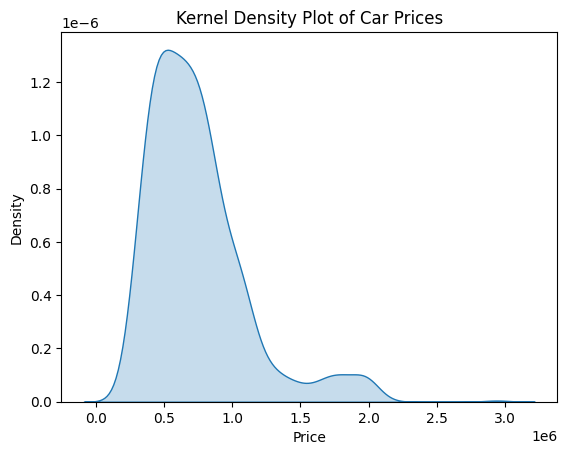

In [3]:
# Summary Statistics
print(cars_data["Price"].describe())

# Kernel Density Plot
sns.kdeplot(cars_data["Price"], fill=True)
plt.title("Kernel Density Plot of Car Prices")
plt.xlabel("Price")
plt.show()

               count          mean           std        min        25%  \
Make                                                                     
Chevrolet        6.0  4.535000e+05  2.466064e+05   267000.0   288500.0   
Datsun           3.0  2.896667e+05  1.050397e+04   279000.0   284500.0   
Ford            52.0  7.211731e+05  1.409277e+05   290000.0   635000.0   
Honda           73.0  7.989726e+05  2.665091e+05   316000.0   581000.0   
Hyundai        305.0  6.918918e+05  2.791597e+05   248000.0   485000.0   
Jeep             4.0  1.499500e+06  1.525134e+05  1290000.0  1447500.0   
Kia              8.0  1.614750e+06  1.190567e+05  1369000.0  1579000.0   
MG Motors       35.0  1.869457e+06  1.216611e+05  1589000.0  1786500.0   
Mahindra        18.0  1.100167e+06  1.755493e+05   796000.0  1037000.0   
Maruti Suzuki  293.0  5.887850e+05  2.160199e+05   237000.0   411000.0   
Nissan           4.0  8.842500e+05  2.895599e+05   475000.0   782500.0   
Renault         68.0  6.625735e+05  2.

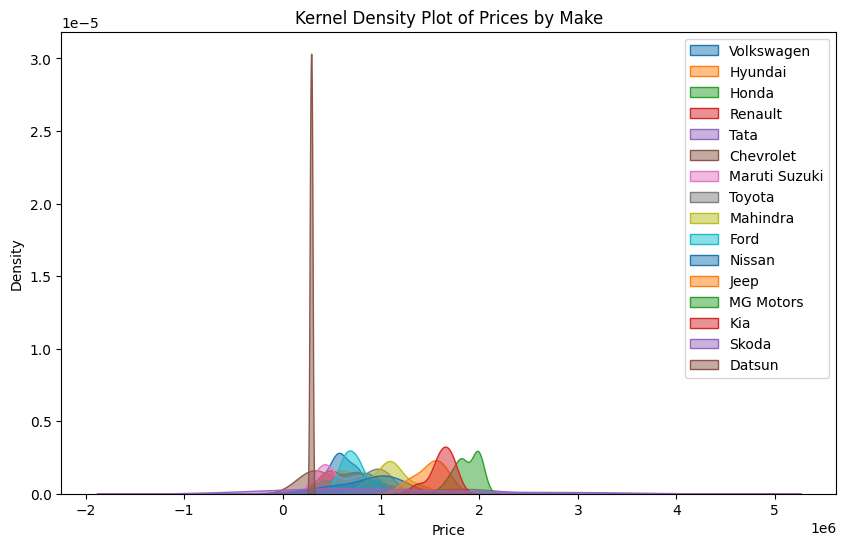

In [ ]:
# Grouped Summary
print(cars_data.groupby("Make")["Price"].describe())

# KDP by Make
plt.figure(figsize=(10,6))
for make in cars_data["Make"].unique():
    sns.kdeplot(cars_data[cars_data["Make"] == make]["Price"], label=make, fill=True, alpha=0.5)
plt.legend()
plt.title("Kernel Density Plot of Prices by Make")
plt.xlabel("Price")
plt.show()

MG Motors, Kia, and Jeep are the most expensive car brands. The average car is about 741,019 but has a very big range as the standard deviation is very big. 

  3. Split the data into an 80% training set and a 20% testing set.

In [5]:
train_df, test_df = train_test_split(cars_data, test_size=0.2, random_state=42)

  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?

In [6]:
num_features = ["Mileage_Run", "Seating_Capacity", "Make_Year"]
X_train, X_test = train_df[num_features], test_df[num_features]
y_train, y_test = train_df["Price"], test_df["Price"]

model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

r2_1 = r2_score(y_test, y_pred1)
rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred1))

print(f"Model 1 - R^2: {r2_1:.4f}, RMSE: {rmse_1:.2f}")

Model 1 - R^2: 0.3150, RMSE: 280302.92


In [7]:
X_train_cat = pd.get_dummies(train_df["Make"], drop_first=True)
X_test_cat = pd.get_dummies(test_df["Make"], drop_first=True)

model2 = LinearRegression()
model2.fit(X_train_cat, y_train)
y_pred2 = model2.predict(X_test_cat)

r2_2 = r2_score(y_test, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred2))

print(f"Model 2 - R^2: {r2_2:.4f}, RMSE: {rmse_2:.2f}")

Model 2 - R^2: 0.4477, RMSE: 251683.65


In [ ]:
X_train_combined = pd.concat([X_train, X_train_cat], axis=1)
X_test_combined = pd.concat([X_test, X_test_cat], axis=1)

model3 = LinearRegression()
model3.fit(X_train_combined, y_train)
y_pred3 = model3.predict(X_test_combined)

r2_3 = r2_score(y_test, y_pred3)
rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred3))

print(f"Model 3 - R^2: {r2_3:.4f}, RMSE: {rmse_3:.2f}")

Model 3 - R^2: 0.6204, RMSE: 208653.01


The joint model performs significantly better than both individual models by combining numerical and categorical predictors. The improvement is more pronounced compared to the numeric model, showing that categorical variables add substantial predictive power.

5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?

In [9]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"Polynomial Model - R^2: {r2_poly:.4f}, RMSE: {rmse_poly:.2f}")

Polynomial Model - R^2: 0.3324, RMSE: 276720.22


It performs worse than the joint model and performs just as well as the worst model (numeric only).

  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

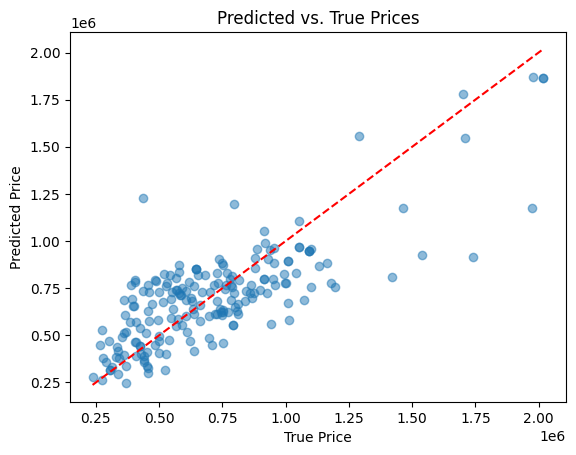

In [10]:
plt.scatter(y_test, y_pred3, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs. True Prices")
plt.show()

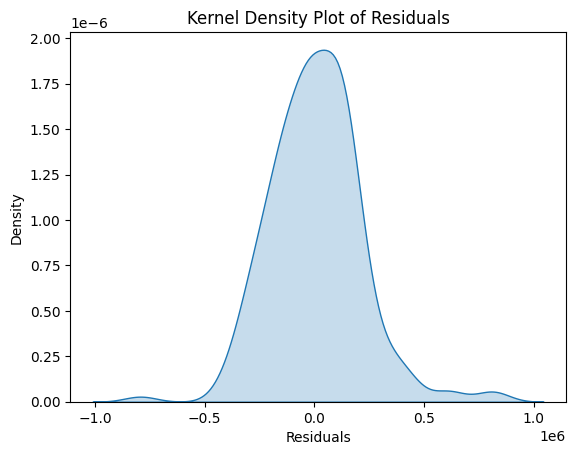

In [11]:
residuals = y_test - y_pred3

sns.kdeplot(residuals, fill=True)
plt.title("Kernel Density Plot of Residuals")
plt.xlabel("Residuals")
plt.show()

**Q4.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.

In [13]:
import pandas as pd

heart_data = pd.read_csv("./data/heart_hw.csv")

# Compute Proportions
p_control = heart_data[heart_data["transplant"] == "control"]["y"].mean()
p_treatment = heart_data[heart_data["transplant"] == "treatment"]["y"].mean()

# Compute ATE
ATE = p_treatment - p_control
print(f"Control Group Survival Rate: {p_control:.4f}")
print(f"Treatment Group Survival Rate: {p_treatment:.4f}")
print(f"Average Treatment Effect (ATE): {ATE:.4f}")

Control Group Survival Rate: 0.1176
Treatment Group Survival Rate: 0.3478
Average Treatment Effect (ATE): 0.2302


2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.

In [14]:
import statsmodels.api as sm

# Convert Transplant to Binary
heart_data["transplant_binary"] = (heart_data["transplant"] == "treatment").astype(int)

# Linear Regression
X = sm.add_constant(heart_data["transplant_binary"]) 
model = sm.OLS(heart_data["y"], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     6.354
Date:                Mon, 24 Mar 2025   Prob (F-statistic):             0.0133
Time:                        16:17:16   Log-Likelihood:                -59.591
No. Observations:                 103   AIC:                             123.2
Df Residuals:                     101   BIC:                             128.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1176      0.07

The regression results show that the estimated survival rate for the control group is 11.76%, matching our earlier calculation. The coefficient on transplant_binary indicates that receiving a transplant increases the survival probability by 23 percentage points, which aligns with the average treatment effect. This effect is statistically significant, suggesting a meaningful difference in survival outcomes. These findings confirm that the OLS model effectively captures the impact of transplants on survival rates.

3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?

In [15]:
# Regression
X = heart_data[["transplant_binary", "age"]]
X = sm.add_constant(X)
model_age = sm.OLS(heart_data["y"], X).fit()
print(model_age.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     8.602
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           0.000357
Time:                        16:19:21   Log-Likelihood:                -54.558
No. Observations:                 103   AIC:                             115.1
Df Residuals:                     100   BIC:                             123.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.7020      0.19

When age is added to the regression, the intercept increases from 0.1176 to 0.7020. This means that when both transplant_binary and age are zero, the predicted survival probability is much higher. The change in the intercept suggests that age has a significant negative effect on survival, meaning older patients have a lower chance of survival. However, the positive effect of transplantation remains significant, reinforcing its role in improving survival rates.

4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.

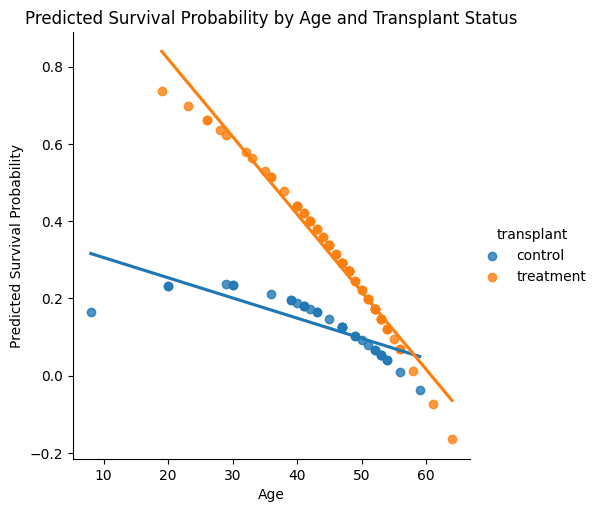

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

# Interaction & Quadratic Terms
heart_data["age_squared"] = heart_data["age"]**2
heart_data["transplant_age_interaction"] = heart_data["transplant_binary"] * heart_data["age"]

# Features and Targets
X = heart_data[["transplant_binary", "age", "age_squared", "transplant_age_interaction"]]
y = heart_data["y"]
X = sm.add_constant(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression
model_flex = sm.OLS(y_train, X_train).fit()

# Predict
heart_data["predicted_y"] = model_flex.predict(X)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Probability
sns.lmplot(data=heart_data, x="age", y="predicted_y", hue="transplant", ci=None)
plt.xlabel("Age")
plt.ylabel("Predicted Survival Probability")
plt.title("Predicted Survival Probability by Age and Transplant Status")
plt.show()

This suggests that age negatively impacts survival probability for both groups, but the effect is much steeper for those who receive a transplant. The control group’s survival probability follows an inverted U-shape, meaning younger and older individuals have lower survival probabilities, while middle-aged individuals have the highest chance of survival. In contrast, the transplant group experiences a steady decline in survival probability as age increases, indicating that older patients benefit less from the procedure. This sharp decline could imply that transplants are riskier for older individuals or that underlying health conditions reduce their effectiveness.

5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

There are several concerns with using models like this to allocate organ transplants. First, such models may reinforce biases present in the data, potentially disadvantaging certain groups based on age, socioeconomic status, or other factors that are correlated with survival but not necessarily with medical need. Second, a purely data-driven approach may not capture important qualitative factors like patient support systems, lifestyle, or post-transplant care access, which can significantly affect outcomes. Additionally, ethical concerns arise if the model prioritizes maximizing overall survival rates over fairness or equity, potentially leading to discrimination against older or higher-risk patients. Finally, transparency and interpretability are critical—patients and medical professionals need to understand how decisions are made, and the model must be continuously monitored to ensure it aligns with ethical medical practices.